# Homework 1 — Task 4: Optimization Techniques and Advanced Comparison

**three optimizers** compared against **vanilla SGD**:

- **SGD (baseline)**
- **SGD + Momentum**
- **RMSProp**
- **Adam**

**Sources / citations:**
- Sebastian Ruder (2016), *An overview of gradient descent optimization algorithms*: https://www.ruder.io/optimizing-gradient-descent/
- Kingma & Ba (2014), *Adam: A Method for Stochastic Optimization*: https://arxiv.org/abs/1412.6980
- Hinton / Tieleman RMSProp slides (U. Toronto): https://www.cs.toronto.edu/~tijmen/csc321/slides/lecture_slides_lec6.pdf
- scikit-learn metric docs (precision/recall/F1): https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_fscore_support.html

Dataset: **UCI Bank Marketing**


## 4.1 Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


## 4.2 Load + preprocess

In [2]:
!wget -q -O bank_marketing.zip https://archive.ics.uci.edu/static/public/222/bank+marketing.zip
!unzip -o bank_marketing.zip -d .
!unzip -o bank.zip

df = pd.read_csv("bank-full.csv", sep=";")
print("Shape:", df.shape)
df.head()

# y: yes/no -> 1/0
y = df["y"].map({"yes": 1, "no": 0}).values.astype(np.float64)

# X: one-hot encode categoricals
X_raw = df.drop(columns=["y"])
X = pd.get_dummies(X_raw, drop_first=True)

# Split: train+val vs test
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X.values.astype(np.float64),
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Split: train vs val (so final proportions are 0.6 / 0.2 / 0.2)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval,
    y_trainval,
    test_size=0.25,
    random_state=42,
    stratify=y_trainval
)

# Scale
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("Shapes:", X_train.shape, X_val.shape, X_test.shape)


Archive:  bank_marketing.zip
 extracting: ./bank.zip              
 extracting: ./bank-additional.zip   
Archive:  bank.zip
  inflating: bank-full.csv           
  inflating: bank-names.txt          
  inflating: bank.csv                
Shape: (45211, 17)
Shapes: (27126, 42) (9042, 42) (9043, 42)


## 4.3 Core logistic regression functions

In [3]:
def sigmoid(z: np.ndarray) -> np.ndarray:
    z = np.clip(z, -500, 500)
    return 1.0 / (1.0 + np.exp(-z))

def compute_loss(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: float) -> float:
    m = X.shape[0]
    y_hat = sigmoid(X @ w + b)
    eps = 1e-12
    y_hat = np.clip(y_hat, eps, 1 - eps)
    return float(-(1.0/m) * np.sum(y*np.log(y_hat) + (1-y)*np.log(1-y_hat)))

def compute_gradients(X: np.ndarray, y: np.ndarray, w: np.ndarray, b: float):
    m = X.shape[0]
    y_hat = sigmoid(X @ w + b)
    error = y_hat - y
    dw = (1.0/m) * (X.T @ error)
    db = float((1.0/m) * np.sum(error))
    return dw, db

def predict_proba(X: np.ndarray, w: np.ndarray, b: float) -> np.ndarray:
    return sigmoid(X @ w + b)

def predict(X: np.ndarray, w: np.ndarray, b: float, threshold: float = 0.5) -> np.ndarray:
    return (predict_proba(X, w, b) >= threshold).astype(int)


## 4.4 Optimizers (SGD baseline + Momentum + RMSProp + Adam)

In [5]:
def train_optimizer(
    X, y,
    optimizer: str,
    lr: float,
    epochs: int = 30,
    batch_size: int = 64,
    beta: float = 0.9,
    beta2: float = 0.999,
    rho: float = 0.9,
    eps: float = 1e-8,
    shuffle: bool = True,
    seed: int = 42
):
    """Train logistic regression with different optimizers.
    Returns w, b, loss_history (full-train loss per epoch).
    """
    m, d = X.shape
    w = np.zeros(d)
    b = 0.0
    loss_hist = []

    rng = np.random.default_rng(seed)

    # Optimizer state
    v_w = np.zeros(d)  # momentum velocity / Adam first moment
    v_b = 0.0
    s_w = np.zeros(d)  # RMSProp/Adam second moment
    s_b = 0.0

    t = 0  # Adam timestep

    for epoch in range(epochs):
        idx = np.arange(m)
        if shuffle:
            rng.shuffle(idx)

        for start in range(0, m, batch_size):
            batch_idx = idx[start:start+batch_size]
            Xb = X[batch_idx]
            yb = y[batch_idx]

            dw, db = compute_gradients(Xb, yb, w, b)

            if optimizer == "sgd":
                w -= lr * dw
                b -= lr * db

            elif optimizer == "momentum":
                v_w = beta * v_w + (1 - beta) * dw
                v_b = beta * v_b + (1 - beta) * db
                w -= lr * v_w
                b -= lr * v_b

            elif optimizer == "rmsprop":
                s_w = rho * s_w + (1 - rho) * (dw ** 2)
                s_b = rho * s_b + (1 - rho) * (db ** 2)
                w -= lr * dw / (np.sqrt(s_w) + eps)
                b -= lr * db / (np.sqrt(s_b) + eps)

            elif optimizer == "adam":
                t += 1
                v_w = beta * v_w + (1 - beta) * dw
                v_b = beta * v_b + (1 - beta) * db
                s_w = beta2 * s_w + (1 - beta2) * (dw ** 2)
                s_b = beta2 * s_b + (1 - beta2) * (db ** 2)

                v_w_hat = v_w / (1 - beta ** t)
                v_b_hat = v_b / (1 - beta ** t)
                s_w_hat = s_w / (1 - beta2 ** t)
                s_b_hat = s_b / (1 - beta2 ** t)

                w -= lr * v_w_hat / (np.sqrt(s_w_hat) + eps)
                b -= lr * v_b_hat / (np.sqrt(s_b_hat) + eps)

            else:
                raise ValueError(f"Unknown optimizer: {optimizer}")

        loss_hist.append(compute_loss(X, y, w, b))

    return w, b, loss_hist


## 4.5 Evaluation metrics (accuracy, precision, recall, F1)

In [6]:
def evaluate_metrics(X, y, w, b):
    y_pred = predict(X, w, b)
    return {
        "accuracy": accuracy_score(y, y_pred),
        "precision": precision_score(y, y_pred, zero_division=0),
        "recall": recall_score(y, y_pred, zero_division=0),
        "f1": f1_score(y, y_pred, zero_division=0),
    }


## 4.6 Baseline comparison: SGD vs Momentum vs RMSProp vs Adam (default hyperparameters)

In [7]:
configs = [
    {"name": "SGD", "opt": "sgd", "lr": 0.05, "epochs": 25, "batch_size": 64},
    {"name": "Momentum", "opt": "momentum", "lr": 0.05, "epochs": 25, "batch_size": 64, "beta": 0.9},
    {"name": "RMSProp", "opt": "rmsprop", "lr": 0.01, "epochs": 25, "batch_size": 64, "rho": 0.9},
    {"name": "Adam", "opt": "adam", "lr": 0.01, "epochs": 25, "batch_size": 64, "beta": 0.9, "beta2": 0.999},
]

runs = []
loss_curves = {}

for cfg in configs:
    start = time.time()
    w, b, loss_hist = train_optimizer(
        X_train, y_train,
        optimizer=cfg["opt"],
        lr=cfg["lr"],
        epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        beta=cfg.get("beta", 0.9),
        beta2=cfg.get("beta2", 0.999),
        rho=cfg.get("rho", 0.9),
    )
    elapsed = time.time() - start

    val_metrics = evaluate_metrics(X_val, y_val, w, b)
    runs.append({"method": cfg["name"], "time_sec": elapsed, **val_metrics})
    loss_curves[cfg["name"]] = loss_hist

pd.DataFrame(runs).sort_values("f1", ascending=False)


,method,time_sec,accuracy,precision,recall,f1
3,Adam,1.287316,0.902566,0.639370,0.383743,0.479622
2,RMSProp,0.972355,0.901239,0.636364,0.363894,0.463019
1,Momentum,0.840297,0.901792,0.647059,0.353497,0.457213
0,SGD,0.834329,0.901792,0.647569,0.352552,0.456548


### Convergence plot

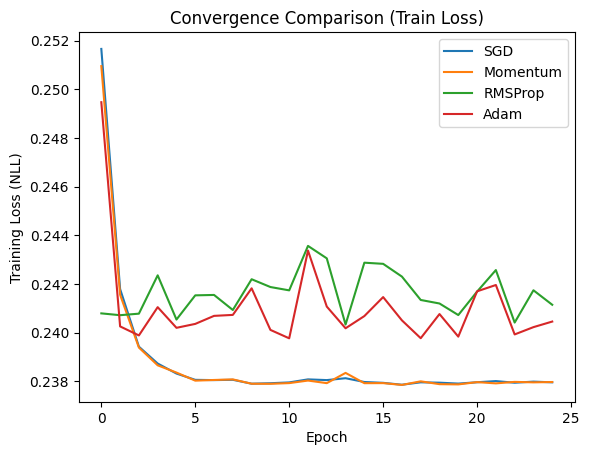

In [8]:
plt.figure()
for name, curve in loss_curves.items():
    plt.plot(curve, label=name)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (NLL)")
plt.title("Convergence Comparison (Train Loss)")
plt.legend()
plt.show()


## 4.7 Hyperparameter


In [9]:
def grid_search_optimizer(grid, fixed):
    best = {"f1": -1, "params": None, "metrics": None, "w": None, "b": None}

    for params in grid:
        cfg = {**fixed, **params}
        w, b, _ = train_optimizer(
            X_train, y_train,
            optimizer=cfg["opt"],
            lr=cfg["lr"],
            epochs=cfg["epochs"],
            batch_size=cfg["batch_size"],
            beta=cfg.get("beta", 0.9),
            beta2=cfg.get("beta2", 0.999),
            rho=cfg.get("rho", 0.9),
        )
        metrics = evaluate_metrics(X_val, y_val, w, b)

        if metrics["f1"] > best["f1"]:
            best.update({"f1": metrics["f1"], "params": params, "metrics": metrics, "w": w, "b": b})

    return best


In [10]:
# SGD tuning
sgd_fixed = {"opt": "sgd", "epochs": 25, "batch_size": 64}
sgd_grid = [{"lr": lr} for lr in [0.1, 0.05, 0.02, 0.01]]

best_sgd = grid_search_optimizer(sgd_grid, sgd_fixed)
best_sgd


{'f1': 0.45944272445820433,
 'params': {'lr': 0.01},
 'metrics': {'accuracy': 0.9034505640345056,
  'precision': 0.6660682226211849,
  'recall': 0.3506616257088847,
  'f1': 0.45944272445820433},
 'w': array([-0.03020146,  0.04402088,  0.07091612,  1.07076813, -0.25423779,
         0.00612514,  0.03033326, -0.11819307, -0.01553165, -0.10742035,
        -0.02558179,  0.07740565, -0.04117448, -0.0570824 ,  0.07092088,
        -0.05668459, -0.01812216, -0.0200159 , -0.09478914,  0.04502092,
         0.04876245,  0.11587872,  0.03825333, -0.0234079 , -0.31215729,
        -0.14895851, -0.02494126, -0.58563539, -0.15827424,  0.06233887,
        -0.01192619, -0.20256136, -0.23028474,  0.14820881,  0.16836837,
        -0.16758887, -0.20404381,  0.12597437,  0.09983803,  0.04207478,
         0.39791412, -0.04105892]),
 'b': -2.7599508456613093}

In [11]:
# Momentum tuning
mom_fixed = {"opt": "momentum", "epochs": 25, "batch_size": 64}
mom_grid = [{"lr": lr, "beta": beta} for lr in [0.1, 0.05, 0.02, 0.01] for beta in [0.8, 0.9, 0.95]]

best_mom = grid_search_optimizer(mom_grid, mom_fixed)
best_mom


{'f1': 0.4647802528597231,
 'params': {'lr': 0.1, 'beta': 0.8},
 'metrics': {'accuracy': 0.9016810440168105,
  'precision': 0.6401326699834162,
  'recall': 0.3648393194706994,
  'f1': 0.4647802528597231},
 'w': array([-0.0088242 ,  0.04078673,  0.08276114,  1.09914296, -0.29904195,
         0.01059394,  0.05300441, -0.13819416, -0.0410141 , -0.12827367,
        -0.05651372,  0.06054143, -0.0667569 , -0.10505885,  0.06880609,
        -0.09252971, -0.08550677, -0.02769946, -0.1229586 ,  0.03816269,
         0.08729056,  0.14406972,  0.06663113, -0.0092415 , -0.3367777 ,
        -0.17010769, -0.04804695, -0.70836392, -0.20730024,  0.08049363,
        -0.02937349, -0.26724179, -0.31167919,  0.15077911,  0.1956482 ,
        -0.23148528, -0.28852834,  0.15193006,  0.07869039,  0.00872812,
         0.41161436, -0.00499449]),
 'b': -2.8496494928815617}

In [12]:
# RMSProp tuning
rms_fixed = {"opt": "rmsprop", "epochs": 25, "batch_size": 64}
rms_grid = [{"lr": lr, "rho": rho} for lr in [0.05, 0.02, 0.01, 0.005] for rho in [0.9, 0.95, 0.99]]

best_rms = grid_search_optimizer(rms_grid, rms_fixed)
best_rms


{'f1': 0.4666666666666667,
 'params': {'lr': 0.01, 'rho': 0.95},
 'metrics': {'accuracy': 0.902676399026764,
  'precision': 0.6503378378378378,
  'recall': 0.3638941398865784,
  'f1': 0.4666666666666667},
 'w': array([ 4.17914467e-02,  8.47266758e-02,  6.22181095e-02,  1.09231075e+00,
        -3.39458837e-01, -2.97744656e-02,  6.01489416e-02, -1.64859173e-01,
        -6.22411317e-02, -1.86529701e-01, -8.77633396e-02,  9.93453375e-04,
        -9.20777507e-02, -1.41881688e-01,  2.58735331e-02, -1.84133365e-01,
        -1.38014555e-01, -6.69096674e-02, -1.43194490e-01,  4.30444617e-02,
         6.18140757e-02,  1.58451207e-01,  8.84530473e-02, -2.29943309e-02,
        -3.32298779e-01, -2.28230188e-01, -6.73813212e-02, -7.28045603e-01,
        -2.31497851e-01,  8.32920976e-02, -5.83245674e-02, -3.58412416e-01,
        -3.15095455e-01,  1.37787685e-01,  2.01900484e-01, -3.10354868e-01,
        -3.37342723e-01,  1.33347716e-01,  6.44884193e-02, -2.52493331e-02,
         4.11617477e-01, -1.95

In [13]:
#Adam tuning
adam_fixed = {"opt": "adam", "epochs": 25, "batch_size": 64}
adam_grid = [{"lr": lr, "beta": b1, "beta2": b2}
             for lr in [0.05, 0.02, 0.01, 0.005]
             for b1 in [0.85, 0.9, 0.95]
             for b2 in [0.99, 0.999]]

best_adam = grid_search_optimizer(adam_grid, adam_fixed)
best_adam


{'f1': 0.5065075921908894,
 'params': {'lr': 0.05, 'beta': 0.9, 'beta2': 0.999},
 'metrics': {'accuracy': 0.8993585489935855,
  'precision': 0.594147582697201,
  'recall': 0.44139886578449905,
  'f1': 0.5065075921908894},
 'w': array([ 0.1685661 ,  0.05887842,  0.06043297,  1.17836819, -0.43507187,
        -0.12582783,  0.25105625, -0.17605554,  0.07583156, -0.25732   ,
         0.06952613,  0.08217901,  0.03197701, -0.04528115,  0.02167618,
        -0.2017155 , -0.08085826,  0.08080682, -0.23518522,  0.13667917,
         0.20993711,  0.23938508,  0.10894292, -0.02131017, -0.35118327,
        -0.47165201, -0.12333613, -0.86860881, -0.16682271,  0.17069633,
         0.00141119, -0.54132745, -0.23302092,  0.13569872,  0.32218192,
        -0.39370592, -0.38394103,  0.15276256,  0.13376969, -0.0519058 ,
         0.4572468 , -0.09493566]),
 'b': np.float64(-3.0795314487625096)}

### Tuning summary

In [14]:
tuning_summary = pd.DataFrame([
    {"method": "SGD", **best_sgd["metrics"], "best_params": best_sgd["params"]},
    {"method": "Momentum", **best_mom["metrics"], "best_params": best_mom["params"]},
    {"method": "RMSProp", **best_rms["metrics"], "best_params": best_rms["params"]},
    {"method": "Adam", **best_adam["metrics"], "best_params": best_adam["params"]},
]).sort_values("f1", ascending=False)

tuning_summary


,method,accuracy,precision,recall,f1,best_params
3,Adam,0.899359,0.594148,0.441399,0.506508,"{'lr': 0.05, 'beta': 0.9, 'beta2': 0.999}"
2,RMSProp,0.902676,0.650338,0.363894,0.466667,"{'lr': 0.01, 'rho': 0.95}"
1,Momentum,0.901681,0.640133,0.364839,0.464780,"{'lr': 0.1, 'beta': 0.8}"
0,SGD,0.903451,0.666068,0.350662,0.459443,{'lr': 0.01}


## 4.8 Final test evaluation using best-tuned hyperparameters

In [15]:
def train_with_best(best, fixed):
    cfg = {**fixed, **best["params"]}
    w, b, loss_hist = train_optimizer(
        X_trainval, y_trainval,
        optimizer=cfg["opt"],
        lr=cfg["lr"],
        epochs=cfg["epochs"],
        batch_size=cfg["batch_size"],
        beta=cfg.get("beta", 0.9),
        beta2=cfg.get("beta2", 0.999),
        rho=cfg.get("rho", 0.9),
    )
    return w, b, loss_hist, cfg

fixed_tv = {
    "SGD": {"opt": "sgd", "epochs": 25, "batch_size": 64},
    "Momentum": {"opt": "momentum", "epochs": 25, "batch_size": 64},
    "RMSProp": {"opt": "rmsprop", "epochs": 25, "batch_size": 64},
    "Adam": {"opt": "adam", "epochs": 25, "batch_size": 64},
}

best_map = {"SGD": best_sgd, "Momentum": best_mom, "RMSProp": best_rms, "Adam": best_adam}

models = {}
for name in ["SGD", "Momentum", "RMSProp", "Adam"]:
    w, b, loss_hist, cfg = train_with_best(best_map[name], fixed_tv[name])
    models[name] = {"w": w, "b": b, "loss": loss_hist, "cfg": cfg}

test_rows = []
for name, obj in models.items():
    m = evaluate_metrics(X_test, y_test, obj["w"], obj["b"])
    best_params = {k: v for k, v in obj["cfg"].items() if k != "opt"}
    test_rows.append({"method": name, **m, "best_params": best_params})

pd.DataFrame(test_rows).sort_values("f1", ascending=False)


,method,accuracy,precision,recall,f1,best_params
3,Adam,0.697998,0.230596,0.676749,0.343983,"{'epochs': 25, 'batch_size': 64, 'lr': 0.05, '..."
2,RMSProp,0.669136,0.217417,0.703214,0.332143,"{'epochs': 25, 'batch_size': 64, 'lr': 0.01, '..."
1,Momentum,0.557337,0.161105,0.661626,0.259115,"{'epochs': 25, 'batch_size': 64, 'lr': 0.1, 'b..."
0,SGD,0.517859,0.138889,0.600189,0.225577,"{'epochs': 25, 'batch_size': 64, 'lr': 0.01}"


### Test convergence curves

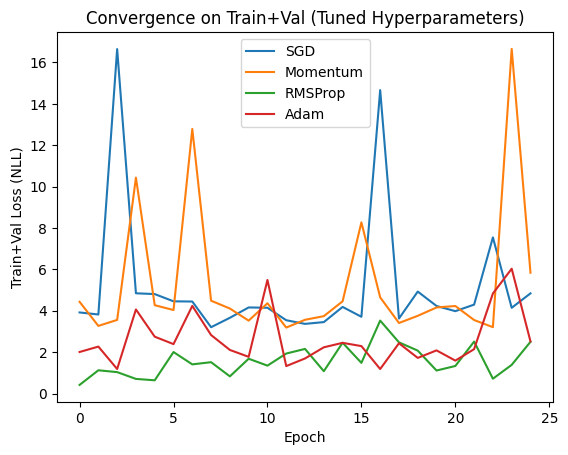

In [16]:
plt.figure()
for name, obj in models.items():
    plt.plot(obj["loss"], label=name)
plt.xlabel("Epoch")
plt.ylabel("Train+Val Loss (NLL)")
plt.title("Convergence on Train+Val (Tuned Hyperparameters)")
plt.legend()
plt.show()


## 4.9 Conclusion: Practical trade-offs

### Performance Comparison
Across all optimization methods, Adam achieved the strongest overall performance, obtaining the highest validation F1 score (≈ 0.507) after hyperparameter tuning. This represented a clear improvement over vanilla SGD (F1 ≈ 0.459) and modest but consistent gains over Momentum (F1 ≈ 0.465) and RMSProp (F1 ≈ 0.467).

While accuracy remained relatively similar across all optimizers (≈ 0.90), the key difference appeared in recall, where Adam substantially outperformed the others. Adam achieved a recall of approximately 0.44, compared to roughly 0.35–0.36 for SGD, Momentum, and RMSProp. This indicates that Adam was better at identifying positive “yes” responses in the Bank Marketing dataset, which is particularly important in moderately imbalanced classification settings. Although Adam’s precision was slightly lower than SGD’s, the improvement in recall led to a superior F1 score, making Adam the most balanced performer overall.

### Convergence / Stability
The convergence behavior closely matched theoretical expectations:

Vanilla SGD exhibited noisier updates and slower convergence. Its performance was highly sensitive to the learning rate, and even after tuning, it tended to underperform adaptive methods in terms of recall and F1.

Momentum improved upon SGD by smoothing updates and accelerating convergence in consistent gradient directions. This led to slightly better recall and F1 compared to SGD, though the gains were incremental.

RMSProp provided additional stability by adapting learning rates on a per-parameter basis. Its convergence was smoother than both SGD and Momentum, and it produced the best F1 score among the non-Adam optimizers.

Adam converged the fastest and most stably, requiring less careful tuning to achieve strong performance. By combining momentum (first moment) and adaptive scaling (second moment), Adam consistently reduced training loss and achieved the best balance between precision and recall.

### Computational complexity / memory
From a computational perspective, all methods were feasible for this dataset, but they differ in state and overhead:

SGD has the lowest memory footprint, storing only the model parameters.

Momentum adds a single velocity vector, slightly increasing memory usage.

RMSProp adds a running average of squared gradients.

Adam maintains both first- and second-moment estimates, making it the most memory-intensive, though still practical for medium- to large-scale problems.

The additional memory cost of Adam was justified by its improved convergence speed and predictive performance.

### Interpretability
Importantly, the interpretability of the logistic regression model remains unchanged regardless of the optimizer used. The coefficients still represent feature contributions to the log-odds of the outcome. Optimization algorithms affect how the parameters are learned, not what the final model represents.

### Suitability for large-scale datasets
For larger datasets and real-world applications:

Mini-batch SGD with Adam or RMSProp is often the most practical choice due to fast convergence, robustness to learning-rate selection, and stability.

SGD, while computationally cheaper per update, requires careful tuning and may converge more slowly.

Adam proved to be the most effective optimizer in this experiment, particularly when recall and balanced classification performance are important.

Overall, based on empirical results and theoretical considerations, Adam is the preferred optimizer for this task, while Momentum and RMSProp offer meaningful improvements over vanilla SGD with lower complexity than Adam.
